In [1]:
#This code computes medians of errors and uses bootstrapping to calculate errors of medians

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib.gridspec as gridspec
import ast
import sys
sys.path.append('machine-scientist/')
sys.path.append('machine-scientist/Prior/')
from mcmc import *
from parallel import *
from fit_prior import read_prior_par
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.stats import bootstrap

In [3]:
def get_errors(resolution):
    #read errors
    errors_approximation=pd.read_csv('../data/'+ 'all_errors_' + resolution +  '.csv',index_col=0)
    columns=["sigma", "function","rmse_nn_train", "rmse_nn_test", "rmse_mdl_train", "rmse_mdl_test", "n", "r"]
    errors_approximation=errors_approximation[columns]

    #divide between train/test
    errors_approximation_train=errors_approximation[["sigma","function", "rmse_nn_train", "rmse_mdl_train","n", "r"]]
    errors_approximation_train=pd.melt(errors_approximation_train,id_vars=["sigma","function", "n", "r"], var_name="error_train",value_name= "value_train")   

    errors_approximation_test=errors_approximation[["sigma","function", "rmse_nn_test", "rmse_mdl_test","n", "r"]]
    errors_approximation_test=pd.melt(errors_approximation_test,id_vars= ["sigma","function", "n", "r"], var_name="error_test", value_name= "value_test")

    #Separate tanh and leaky ReLU
    errors_t_tr=errors_approximation_train[errors_approximation_train['function']=='tanh']
    errors_t_tt=errors_approximation_test[errors_approximation_test['function']=='tanh']

    errors_l_tr=errors_approximation_train[errors_approximation_train['function']=='leaky_ReLU']
    errors_l_tt=errors_approximation_test[errors_approximation_test['function']=='leaky_ReLU']

    return errors_t_tr, errors_t_tt, errors_l_tr, errors_l_tt

In [4]:
resolution='1x' #0.5x, 1x, 2x, 4e-3x

errors_tanh_train, errors_tanh_test, errors_leaky_train, errors_leaky_test=get_errors(resolution)



In [6]:
#Plot results
#Define figure size in cm                                                                           
cm = 1/2.54 #convert inch to cm                                                                     
width = 8*cm; height=6*cm

Extensions=['.png', '.pdf']

#colors from seaborn's colorblind palette
color_data=sns.color_palette("colorblind")[0]
color_noise=sns.color_palette("colorblind")[7]
color_ann=sns.color_palette("colorblind")[4]
color_bms=sns.color_palette("colorblind")[2]

color_ann='#de2d26'
color_bms='#3182bd'

#Fonts and sizes                                                                                    
size_axis=12;size_ticks=10;size_title=5
line_w=1;marker_s=3 #width and marker size                                                          
m_size=6

output_path='../results/'

resamples=100000; bs_seed=1111
ymin=1e-4;ymax=0.75

<Figure size 944.882x708.661 with 0 Axes>

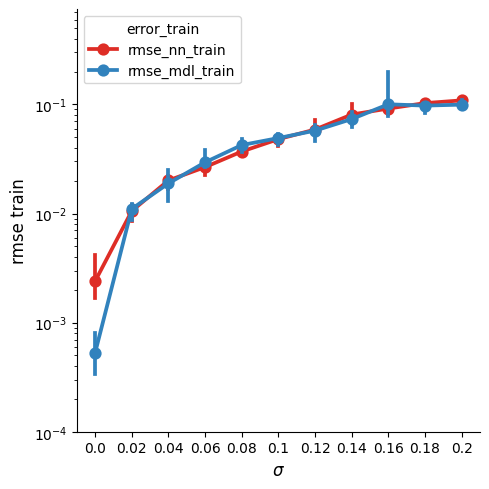

<Figure size 944.882x708.661 with 0 Axes>

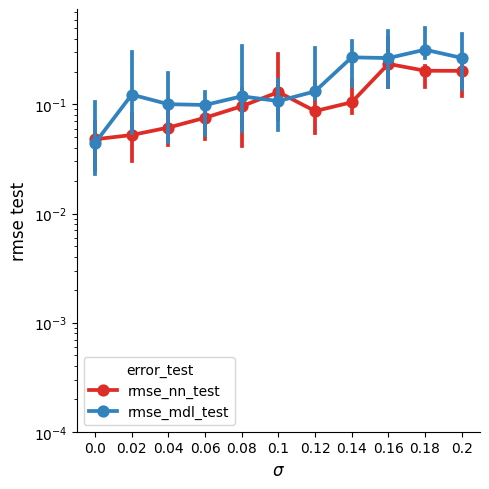

In [7]:
#tanh - rmse train
fig=figure(figsize=(width,height), dpi=300)
sns.catplot(data=errors_tanh_train, x='sigma', y='value_train', hue='error_train', kind='point', estimator='median',
            errorbar=('ci', 95),n_boot=resamples, seed=bs_seed, palette=[color_ann, color_bms],legend_out=False)


#labels, limits, and ticks
plt.xlabel(r'$\sigma$',fontsize=size_axis);plt.ylabel('rmse train',fontsize=size_axis)
plt.yscale("log")
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)

plt.ylim(ymin,ymax)

plt.tight_layout()

name_fig='approximation_medians_tanh_' + resolution + '_resolution'
#name_fig='approximation_medians_tanh_' + resolution + '_resolution_old' 
plt.savefig(output_path+name_fig + '.svg',dpi=300)
plt.savefig(output_path+name_fig + '.png',dpi=300)

#tanh - rmse test
fig=figure(figsize=(width,height), dpi=300)

sns.catplot(data=errors_tanh_test, x='sigma', y='value_test', hue='error_test', kind='point', estimator='median',
            errorbar=('ci', 95),n_boot=resamples, seed=bs_seed, palette=[color_ann, color_bms],legend_out=False)
plt.yscale("log")

#labels, limits, and ticks
plt.xlabel(r'$\sigma$',fontsize=size_axis) 
plt.ylabel('rmse test',fontsize=size_axis)


plt.ylim(ymin,ymax)

plt.tight_layout()

name_fig='test_medians_tanh_' + resolution + '_resolution'
#name_fig='test_medians_tanh_' + resolution + '_resolution_old' 
plt.savefig(output_path+name_fig + '.svg',dpi=300)
plt.savefig(output_path+name_fig + '.png',dpi=300)

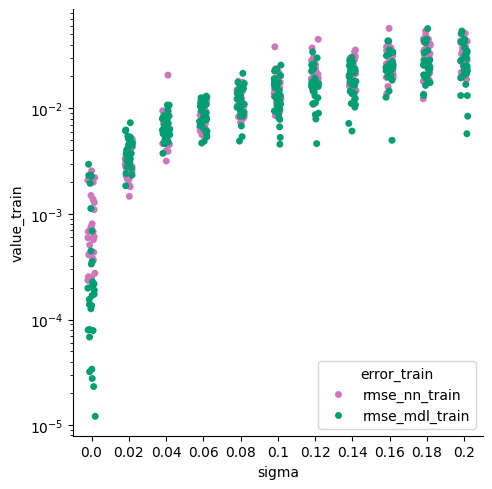

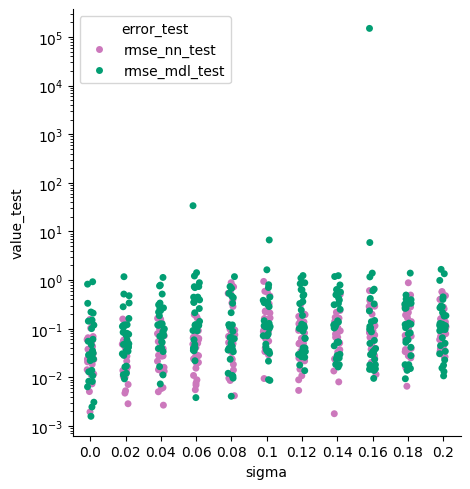

In [16]:
#Individual predictions
sns.catplot(data=errors_tanh_train, x='sigma', y='value_train', hue="error_train",palette=[color_ann, color_bms],legend_out=False)
plt.yscale("log")
name_fig='approximation_medians_tanh_points_' + resolution + '_resolution'
plt.savefig(output_path+name_fig + '.png',dpi=300)

sns.catplot(data=errors_tanh_test, x='sigma', y='value_test', hue="error_test",palette=[color_ann, color_bms],legend_out=False)
plt.yscale("log")
name_fig='test_medians_tanh_points_' + resolution + '_resolution'
plt.savefig(output_path+name_fig + '.png',dpi=300)



<Figure size 944.882x708.661 with 0 Axes>

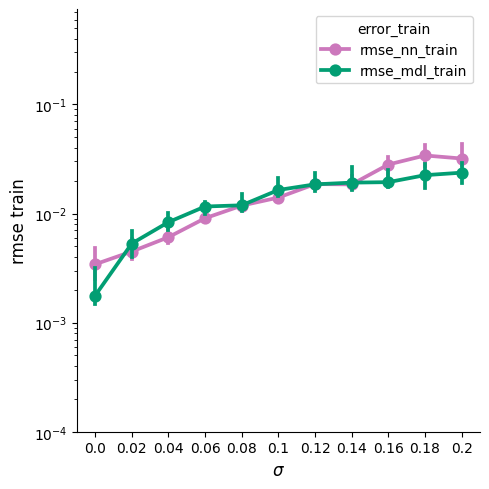

<Figure size 944.882x708.661 with 0 Axes>

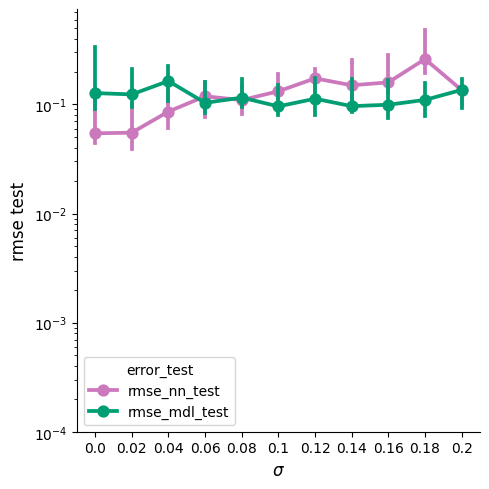

In [17]:
#leaky - rmse train
fig=figure(figsize=(width,height), dpi=300)

sns.catplot(data=errors_leaky_train, x='sigma', y='value_train', hue='error_train', kind='point', estimator='median',
            errorbar=('ci', 95),n_boot=resamples, seed=bs_seed, palette=[color_ann, color_bms],legend_out=False)
plt.yscale("log")

#labels, limits, and ticks
plt.xlabel(r'$\sigma$',fontsize=size_axis) 
plt.ylabel('rmse train',fontsize=size_axis)

plt.ylim(ymin,ymax)

plt.tight_layout()

name_fig='approximation_medians_leaky_' + resolution + '_resolution'
plt.savefig(output_path+name_fig + '.svg',dpi=300)
plt.savefig(output_path+name_fig + '.png',dpi=300)

#leaky - rmse test
fig=figure(figsize=(width,height), dpi=300)

sns.catplot(data=errors_leaky_test, x='sigma', y='value_test', hue='error_test', kind='point', estimator='median',
            errorbar=('ci', 95),n_boot=resamples, seed=bs_seed, palette=[color_ann, color_bms],legend_out=False)
plt.yscale("log")

#labels, limits, and ticks
plt.xlabel(r'$\sigma$',fontsize=size_axis) 
plt.ylabel('rmse test',fontsize=size_axis)

plt.ylim(ymin,ymax)

plt.tight_layout()

name_fig='test_medians_leaky_' + resolution + '_resolution'
plt.savefig(output_path+name_fig + '.svg',dpi=300)
plt.savefig(output_path+name_fig + '.png',dpi=300)

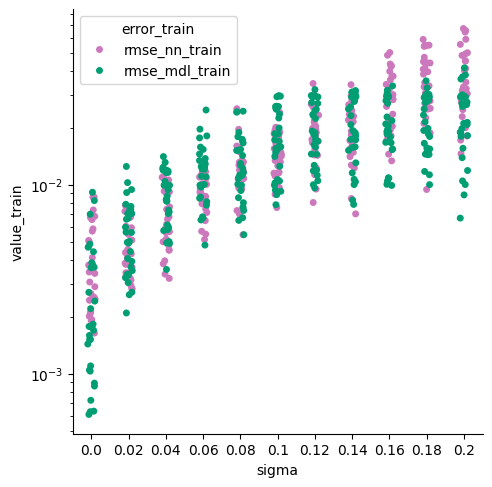

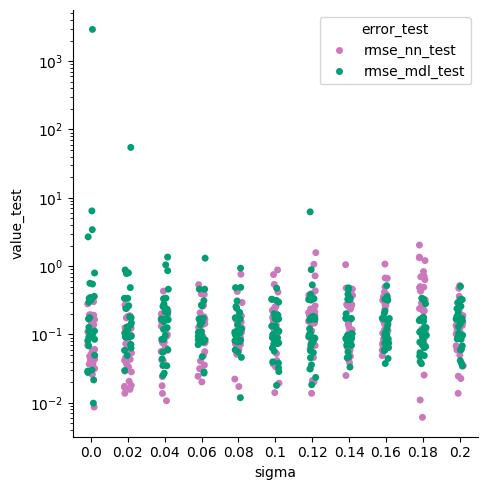

In [18]:
#Individual predictions
sns.catplot(data=errors_leaky_train, x='sigma', y='value_train', hue="error_train",palette=[color_ann, color_bms],legend_out=False)
name_fig='approximation_medians_leaky_points_' + resolution + '_resolution'
plt.yscale("log")

sns.catplot(data=errors_leaky_test, x='sigma', y='value_test', hue='error_test',palette=[color_ann, color_bms],legend_out=False)
name_fig='test_medians_leaky_points_' + resolution + '_resolution'
plt.yscale("log")